### Sudoku

&nbsp;

Sudoku is a logic-based, combinatorial number-placement puzzle. Despite its Japanese name, the game was actually invented by an American and later gained popularity in Japan. 

There are many ways for computer algorithms to solve Sudoku. Here we use vertex coloring to solve the puzzle via maximum independent set. Vertex coloring guarantees no adjacent vertex should have the same color. As long as we can create a proper data structure for Sudoku puzzle, we are able to find the optimal vertex coloring scheme. However, the optimal graph coloring is in fact an NP-hard problem as mentioned in graph coloring session. There are plenty of greedy algorithms but none really work very well on Sudoku. 

To avoid brute force, we tackle the optimal vertex coloring via maximum independent set. The maximum independent set is also an NP-hard problem with plenty of approximation algorithms not working well. So we apply a trick. The maximum independent set in a graph ADT is a maximum clique in a complement graph. It is much easier to search all the maximal cliques via Bron Kerbosch algorithm. We merely need to discover the maximal clique with maximum cardinality. Well, this quid pro quoi method has its faux pas. The time complexity shoots through the roof! Thus, we only take 4 by 4 Sudoku for the purpose of demonstration. Binary integer linear programming is the recommended way to solve Sudoku.

Reference to the data structure for maximum independent set is on the page 147 in the link below

http://www.iitg.ac.in/psm/GIAN-DNA/material/3-MIS-wo.pdf

Reference to maximal clique and Bron Kerbosch algorithm

https://github.com/je-suis-tm/graph-theory/blob/master/maximal%20clique.ipynb

Reference to maximum independent set

https://github.com/je-suis-tm/graph-theory/blob/master/maximum%20independet%20set.ipynb

Reference to graph coloring

https://github.com/je-suis-tm/graph-theory/blob/master/graph%20coloring.ipynb

Reference to Binary Integer Linear Programming for Sudoku

https://github.com/je-suis-tm/operation-research/blob/main/sudoku.ipynb

In [1]:
import numpy as np
import os
os.chdir('K:/ecole/github/televerser')
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#graph adt
#check the below link for more details
# https://github.com/je-suis-tm/graph-theory/blob/master/graph.py
import graph

### functions

In [2]:
#convert sudoku to graph structure
def create_graph_structure(num):

    ADT=graph.graph()

    #locate the coordinates of submatrices
    pivots=[i for i in range(0,num,int(num**0.5))]
    intervals=[range(i,i+int(num**0.5)) for i in pivots]
    submatrices=[(i,j) for i in intervals for j in intervals]

    #connect elements in the same submatrix
    for submatrix in submatrices:
        vertices=[(i,j) for i in submatrix[0] for j in submatrix[1]]
        for i in range(len(vertices)):
            for j in range(i+1,len(vertices)):
                ADT.append(vertices[i],vertices[j],0)
                ADT.append(vertices[j],vertices[i],0)    

    #connect elements in the same column
    for latitude in range(num):
        cols=[(latitude,i) for i in range(num)]
        for i in range(len(cols)):
            for j in range(i+1,len(cols)):
                ADT.append(cols[i],cols[j],0)
                ADT.append(cols[j],cols[i],0)        

    #connect elements in the same row
    for longitude in range(num):
        rows=[(i,longitude) for i in range(num)]
        for i in range(len(rows)):
            for j in range(i+1,len(rows)):
                ADT.append(rows[i],rows[j],0)
                ADT.append(rows[j],rows[i],0)
                
    return ADT

In [3]:
#prepare sudoku graph for coloring
def get_sudoku_graph(puzzle):

    #convert sudoku to graph
    num=puzzle.shape[0]
    ADT=create_graph_structure(num)
    
    #get filled cells
    exclude_vertices=[(np.where(puzzle!=0)[0][i],np.where(puzzle!=0)[1][i]) for i in range(len(np.where(puzzle!=0)[0]))]
    
    coloring_graph=graph.graph()    
    for node in ADT.vertex():
        
        #create clones to form cliques
        for from_color in range(1,num+1):
            for to_color in range(from_color+1,num+1):
                coloring_graph.append((node[0],node[1],from_color),
                                      (node[0],node[1],to_color),0)
                coloring_graph.append((node[0],node[1],to_color),
                                      (node[0],node[1],from_color),0)

        #connect clones
        for link in ADT.edge(node):
            for color in range(1,num+1):
                coloring_graph.append((node[0],node[1],color),
                                      (link[0],link[1],color),0)
                coloring_graph.append((link[0],link[1],color),
                                      (node[0],node[1],color),0)

    #remove filled cells
    for node in exclude_vertices:
        current_vertex=(node[0],node[1],puzzle[node])
        for neighbor in coloring_graph.edge(current_vertex):
            coloring_graph.remove(neighbor)
        coloring_graph.remove(current_vertex)
        

    return coloring_graph

In [4]:
#create output
#convert flatten matrix to a regular n by n matrix
def extract_solution(puzzle,ans):

    #initialize
    solution=puzzle.copy()

    #revert flatten matrix to real sudoku
    for i in ans:
        solution[(i[0],i[1])]=i[2]

    return solution

In [5]:
#viz sudoku
def viz(sudoku,colors):

    ax=plt.figure(figsize=(5,5)).add_subplot(111)
    
    #plot blocks with graph coloring
    for latitude in range(sudoku.shape[0]):
        for longitude in range(sudoku.shape[1]):
            ax.add_patch(patches.Rectangle((latitude,longitude),
                    1,1,facecolor=colors[sudoku[latitude][longitude]],
                                           edgecolor='k',fill=True))

    #show answers
    for latitude in range(sudoku.shape[0]):
        for longitude in range(sudoku.shape[1]):
            plt.text(latitude+0.5,longitude+0.5,
                     str(sudoku[latitude][longitude]),
                     ha='center',va='center',fontsize=20)

    plt.xlim((0,sudoku.shape[0]))
    plt.ylim((0,sudoku.shape[1]))
    plt.xticks([])
    plt.yticks([])
    plt.show()

### run

In [6]:
#due to the crazy time complexity
#we will stick to 4 by 4 sudoku
puzzle=np.array([
[0,0,2,0],
[0,0,0,1],
[0,1,0,0],
[4,0,0,2]])

In [7]:
#create graph structure suitable for graph coloring
coloring_graph=get_sudoku_graph(puzzle)

In [8]:
#create the inverse of coloring graph
complement_graph=graph.graph()
for node in coloring_graph.vertex():
    connections=[link for link in coloring_graph.vertex() if link not in coloring_graph.edge(node)]
    for link in connections:
        complement_graph.append(node,link,0)

In [9]:
#the maximum independent set of a graph
#is the maximum clique of its complement graph
#hence we find out all the maximal cliques first
mis=list(graph.bron_kerbosch(complement_graph,
                             P=set(complement_graph.vertex())))

In [10]:
#select the maximal clique with the maximum cardinality
#if there are multiple
#we pick the first
ans=max(mis,key=len)

In [11]:
#display the result in matrix form
sudoku=extract_solution(puzzle,ans)
sudoku

array([[1, 4, 2, 3],
       [3, 2, 4, 1],
       [2, 1, 3, 4],
       [4, 3, 1, 2]])

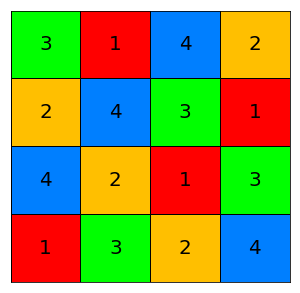

In [12]:
#viz
viz(sudoku,{1:'#ff0000',2:'#ffbf00',3:'#00ff00',4:'#007fff'})